In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import time
import sys
import os
sys.path.append('..')
from datetime import datetime
from util.Stopwatch import Stopwatch
import socket
%matplotlib inline

DB_PATH = '../local/db/telemetry.db'
assert(os.path.exists(DB_PATH))
IMG_OUT = 'plot_repair.png'
HOST = 'chuck'
LOCAL_HOSTNAME = socket.gethostname()

plt.style.use('ggplot')

In [21]:
def get_sensors(db_path, host):
    with sqlite3.connect(db_path) as con:
        cur = con.cursor()
        cur.execute("SELECT * FROM sensors WHERE host='{}';".format(host))
        sensors = {s[2]: s[0] for s in cur.fetchall()}
    return sensors

sensors = get_sensors(DB_PATH, HOST)
sensors_rev = {v:k for k, v in sensors.iteritems()}

In [22]:
def read_df(db_path, host=None, sw=None, from_id=0, deduplicate=False, table='telemetry', immediate=False, **kwargs):
    # TODO: incremental reads
    # TODO: Select only current host
    if sw is None:
        sw = Stopwatch('Dataframe loading')

    with sqlite3.connect(db_path) as con:
        if not immediate:
            df = pd.read_sql_query('SELECT * FROM {table} where id>{id};'.format(table=table, id=from_id), con)
        else:
            df = pd.read_sql_query('SELECT * FROM {table} where id>{id};'.format(table=table, id=from_id), con,
                                   index_col='timestamp', parse_dates={'timestamp': {'unit':'s'}})
    sw.event('SQL raw data into df' + '' if not immediate else 'with timestamp to dates')

    # timestamps as datetime array
    if not immediate:
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        sw.event('convert timestamps to datetime')
    
    # type as category (sensor type)
    df['type'] = df['type'].astype('category')
    newcats = [sensors_rev[c] for c in df['type'].cat.categories]
    df['type'].cat.categories = newcats
    sw.event('type as category')
  
    #return df
    if deduplicate:
        df.drop_duplicates(subset=['timestamp', 'type'], inplace=True)
        sw.event('De-duplication')

    pivoted, _ = prepare_df(df, sw, **kwargs)
    
    return pivoted, sw

In [23]:
def prepare_df(df, sw=None, resample=False):
    if sw is None:
        sw = Stopwatch('Pivot and adjust data frame')
    
    pivoted = df.pivot(index = 'timestamp', columns='type', values='value') \
                .tz_localize('UTC').tz_convert('Europe/Amsterdam')
    sw.event('pivot table')
    
    if resample:
        pivoted = pivoted.resample(resample, how='mean')
        sw.event('resampling')

    # adjust time zone
    pivoted = pivoted
    sw.event('adjust timezone')

    # Get rid of false temp values
    pivoted.temp[(pivoted['light'] > 250) & (pivoted.index < '2016-03-10 07:03:57.603722+01:00')] = np.NaN
    sw.event('Removing false temp values')
    
    return pivoted, sw

In [24]:
def make_plot(db_path, host, sw=None, **kwargs):
    if sw is None:
        sw = Stopwatch('Make Plot')
    
    df, sw = read_df(db_path, host, sw=sw, **kwargs)
    plot(df, sw=sw)
    
    return sw

In [30]:
def plot(df, sw=None, width=None):
    if sw is None:
        sw = Stopwatch('Plotting')

    # Throwing the data into a plot
    axes = df.plot(secondary_y=['temp', 'ds_temp'], mark_right=False, style=['r', 'g', 'b', 'c'])
    sw.event('plot pivoted dataframe')

    fig = plt.gcf()
    
    # limits
    axes.set_ylim((0, 1024))
    axes.right_ax.set_ylim((10, 40))
    
    # Grid lines and ticks
    rticks = axes.right_ax.get_yticks()
    rmin, rmax = min(rticks), max(rticks)
    lmin, lmax = axes.get_ylim()
    lrange = lmax - lmin
    rrange = rmax - rmin
    factor = lrange/rrange
    axes.set_yticks([(t-rmin)*factor for t in rticks])
    axes.set_yticklabels([])
    
    axes.right_ax.grid([])
    axes.grid()
    
    # Fiddling with axis labeling
    axes.set_ylabel(u'Raw ADC values')
    axes.right_ax.set_ylabel(u'Temperature °C')

    axes.set_xlabel('')    
    fig.autofmt_xdate(bottom=0.2, rotation=0, ha='center')

    # Messing with the legend
    axes.legend(loc='upper left', shadow=True, fontsize='x-large')
    axes.right_ax.legend(loc='upper right', shadow=True, fontsize='x-large')

    # Annotation at bottom
    elapsed = sw.elapsed()
    axes.annotate('in {elapsed:.1f} s on {hostname}, {timestamp}'.format(elapsed=elapsed,
                                                                            hostname=LOCAL_HOSTNAME,
                                                                            timestamp=datetime.now().strftime('%Y-%m-%d %H:%M'),),
                  xy=(1, 0), xycoords='axes fraction', fontsize=10, xytext=(0, -55),
                  textcoords='offset points', ha='right', va='top')
    sw.event('annotate axes')

    # resampled to 6 minutes, 240 points per day
    # 1 inch = 2.54 cm, * 0.944881889764 = 2.4cm = .1mm/data point * number of days plotted
    if width is None:
        delta = (df.index[-1] - df.index[0]) / pd.Timedelta('1 Day')
        width = delta*0.944881889764

    fig.set_size_inches(width, 5.5)
    fig.savefig('plot.png', dpi=150, transparent=False, bbox_inches='tight', pad_inches=0)
    sw.event('save plot file')
    plt.close();
    return sw

timings = make_plot(DB_PATH, HOST, resample='6min')
timings.report()


Timings for Make Plot
2.64s (2.64s): SQL raw data into df
4.54s (1.90s): convert timestamps to datetime
4.56s (0.02s): type as category
5.28s (0.72s): pivot table
5.38s (0.10s): resampling
5.38s (0.00s): adjust timezone
5.38s (0.00s): Removing false temp values
5.63s (0.25s): plot pivoted dataframe
5.64s (0.01s): annotate axes
6.87s (1.23s): save plot file


In [29]:
!rsync -avh --progress VersedSquid:~/code/telemetry/db/telemetry.db ../local/db/
#timings = make_plot(DB_PATH, HOST, resample='5min', table='telemetry', from_id=int(1.2e6))
#timings.report()
#!scp plot.png lychnobite.me:~/projects/static/

receiving incremental file list
telemetry.db
         69.50M 100%   13.53MB/s    0:00:04 (xfr#1, to-chk=0/1)

sent 56.17K bytes  received 5.38M bytes  473.09K bytes/sec
total size is 69.50M  speedup is 12.78


In [26]:
p, s, d = read_df(DB_PATH, HOST)

ValueError: need more than 2 values to unpack

In [27]:
with sqlite3.connect(DB_PATH) as con:
    df = pd.read_sql_query('SELECT * FROM {table} where id>{id};'.format(table='telemetry', id=0), con,
                           index_col='timestamp', parse_dates={'timestamp': {'unit':'s'}})
print df.head()
#df.pivot(index='timestamp', columns='type', values='value')
%timeit df.value[df.type==1]

                            Id  type   value
timestamp                                   
2016-02-12 17:50:43.231437   1     3     NaN
2016-02-12 17:50:43.231437   2     2  116.00
2016-02-12 17:50:43.231437   3     1   25.38
2016-02-12 17:50:48.292462   4     3     NaN
2016-02-12 17:50:48.292462   5     2  114.62
1 loops, best of 3: 986 ms per loop


In [135]:
#%timeit make_plot(DB_PATH, HOST, resample=False)
#%timeit make_plot(DB_PATH, HOST, resample='30Min')
%timeit make_plot(DB_PATH, HOST, resample='6min')
%timeit make_plot(DB_PATH, HOST, resample='6min', immediate=True)

1 loops, best of 3: 3.42 s per loop


KeyError: 'timestamp'

receiving incremental file list
./
2016_w13-chuck.csv
chuck_2016-03-28.csv

sent 503 bytes  received 17.91K bytes  12.28K bytes/sec
total size is 67.80K  speedup is 3.68


/home/reichler/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


NameError: name 'spans' is not defined

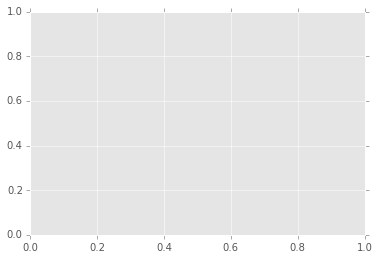

In [31]:
!rsync -avh VersedSquid:~/code/telemetry/local/db/ ../local/db/
df = pd.read_csv('../local/db/chuck_2016-03-28.csv', names=['timestamp', 'type', 'value'])
df.timestamp = df.timestamp.astype('datetime64[s]')
df.set_index('timestamp', inplace=True)
df = df.drop(['timestamp'])
df = df.tz_localize('UTC').tz_convert('Europe/Amsterdam')
df.type.loc[df.type=='ds_temp'] = 1
df.type.loc[df.type=='light'] = 2
df.type.loc[df.type=='soil'] = 3;
df.type.astype('uint8');

fig = plt.figure()
axes = fig.add_subplot(111)

# night background
for span in spans(df):
    plt.axvspan(span[0], span[1], facecolor='0.2', alpha=0.3)

groups = df.groupby('type')
groups.get_group(2).value.resample('6min').plot(ax=axes, style='k', label=r'light')
groups.get_group(3).value.plot(ax=axes, style='b', label=r'$\theta_{soil}$')

axes.set_ylim((0, 1023))
# handles, labels = axes.get_legend_handles_labels()
# handles.append(ep_artist)
# axes.legend(handles=handles, loc=2)
axes.legend(loc=2)
axes.set_xlabel('')
axes.set_yticks([])
axes.set_ylabel(u'raw ADC values')

# temp
axes_r = axes.twinx()
groups.get_group(1).value.plot(ax=axes_r, style='r', label=r'$T_{ambient}$')

axes_r.set_ylim((15, 35))
axes_r.set_ylabel(u'Temperature (°C)')
axes_r.legend()


delta = (df.index[-1] - df.index[0]) / pd.Timedelta('1 Day')
width = delta*0.944881889764*8

fig.set_size_inches(width, 5)